Методы и алгоритмы обработки слабоструктурированных данных
Лабораторная работа №5 
Болотов М.В. АСУ4-22-1м

In [14]:
import os
import nltk
import zipfile
import string
import pymorphy2
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [15]:
nltk.download('stopwords')                                                                   # Загрузка списка стоп-слов из библиотеки NLTK

stop_words = set(nltk.corpus.stopwords.words('russian'))                                     # Получение списка стоп-слов для русского языка

morph = pymorphy2.MorphAnalyzer()                                                            # Создание объекта для лемматизации слов

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\79125\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
def process_text(text):                                                                      # Функция для обработки текста файла: токенизация, удаление стоп-слов и лемматизация
    tokens = nltk.word_tokenize(text)                                                        # Токенизация текста
    tokens = [token for token in tokens if token not in string.punctuation + '«»']           # Удаление знаков препинания и кавычек
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]         # Удаление стоп-слов
    lemmatized_tokens = [morph.parse(token)[0].normal_form for token in filtered_tokens]     # Лемматизация токенов
    return lemmatized_tokens



In [17]:
def process_folder(folder_path):                                                             # Функция для обработки файлов в указанной папке
    corpus = []
    for filename in os.listdir(folder_path):                                                 # Перебор файлов в папке
        if filename.endswith('.txt'):
            file_path = os.path.join(folder_path, filename) 
            with open(file_path, 'r', encoding='utf-8') as file:                             # Чтение текста из файла
                text = file.read()
                processed_text = process_text(text)                                          # Обработка текста файла
                corpus.append(' '.join(processed_text))                                      # Объединение токенов в строку
    return corpus

In [18]:
def plot_top_words(model, feature_names, n_top_words, title):                                # Функция для визуализации топ-слов для каждой темы
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [19]:
zip_file_path = r"C:\Users\79125\OneDrive\Рабочий стол\Учёба ПНИПУ АСУ\4 семестр\Методы и алгоритмы обработки слабоструктурированных данных\lr5\2021_SPORT.zip" 
extraction_dir = r"C:\Users\79125\OneDrive\Рабочий стол\Учёба ПНИПУ АСУ\4 семестр\Методы и алгоритмы обработки слабоструктурированных данных\lr5\расп"

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:                                         # Извлечение файлов из архива
    zip_ref.extractall(extraction_dir)

In [20]:
corpus_combined = []                                                                         # Создание корпуса для каждой папки в extraction_dir
for folder in os.listdir(extraction_dir):
    folder_path = os.path.join(extraction_dir, folder)
    if os.path.isdir(folder_path):
        corpus = process_folder(folder_path)                                                 # Обработка файлов в папке
        corpus_combined.extend(corpus)

In [21]:
count_vectorizer = CountVectorizer(max_features=1000)                                        # Создание векторного представления каждого текста с использованием CountVectorizer
X_count = count_vectorizer.fit_transform(corpus_combined)

In [22]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000)                                        # Создание векторного представления каждого текста с использованием TfidfVectorizer
X_tfidf = tfidf_vectorizer.fit_transform(corpus_combined)

In [23]:
n_topics = 10                                                                                # Количество тем
n_top_words = 20                                                                             # Количество топ-слов

nmf_count = NMF(n_components=n_topics, random_state=42)                                      # Модель NMF с CountVectorizer
nmf_count.fit(X_count)

nmf_tfidf = NMF(n_components=n_topics, random_state=42)                                      # Модель NMF с TfidfVectorizer
nmf_tfidf.fit(X_tfidf)

lda_count = LatentDirichletAllocation(n_components=n_topics, random_state=42)                # Модель LDA с CountVectorizer
lda_count.fit(X_count)

lda_tfidf = LatentDirichletAllocation(n_components=n_topics, random_state=42)                # Модель LDA с TfidfVectorizer
lda_tfidf.fit(X_tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()                               # Получение списка признаков

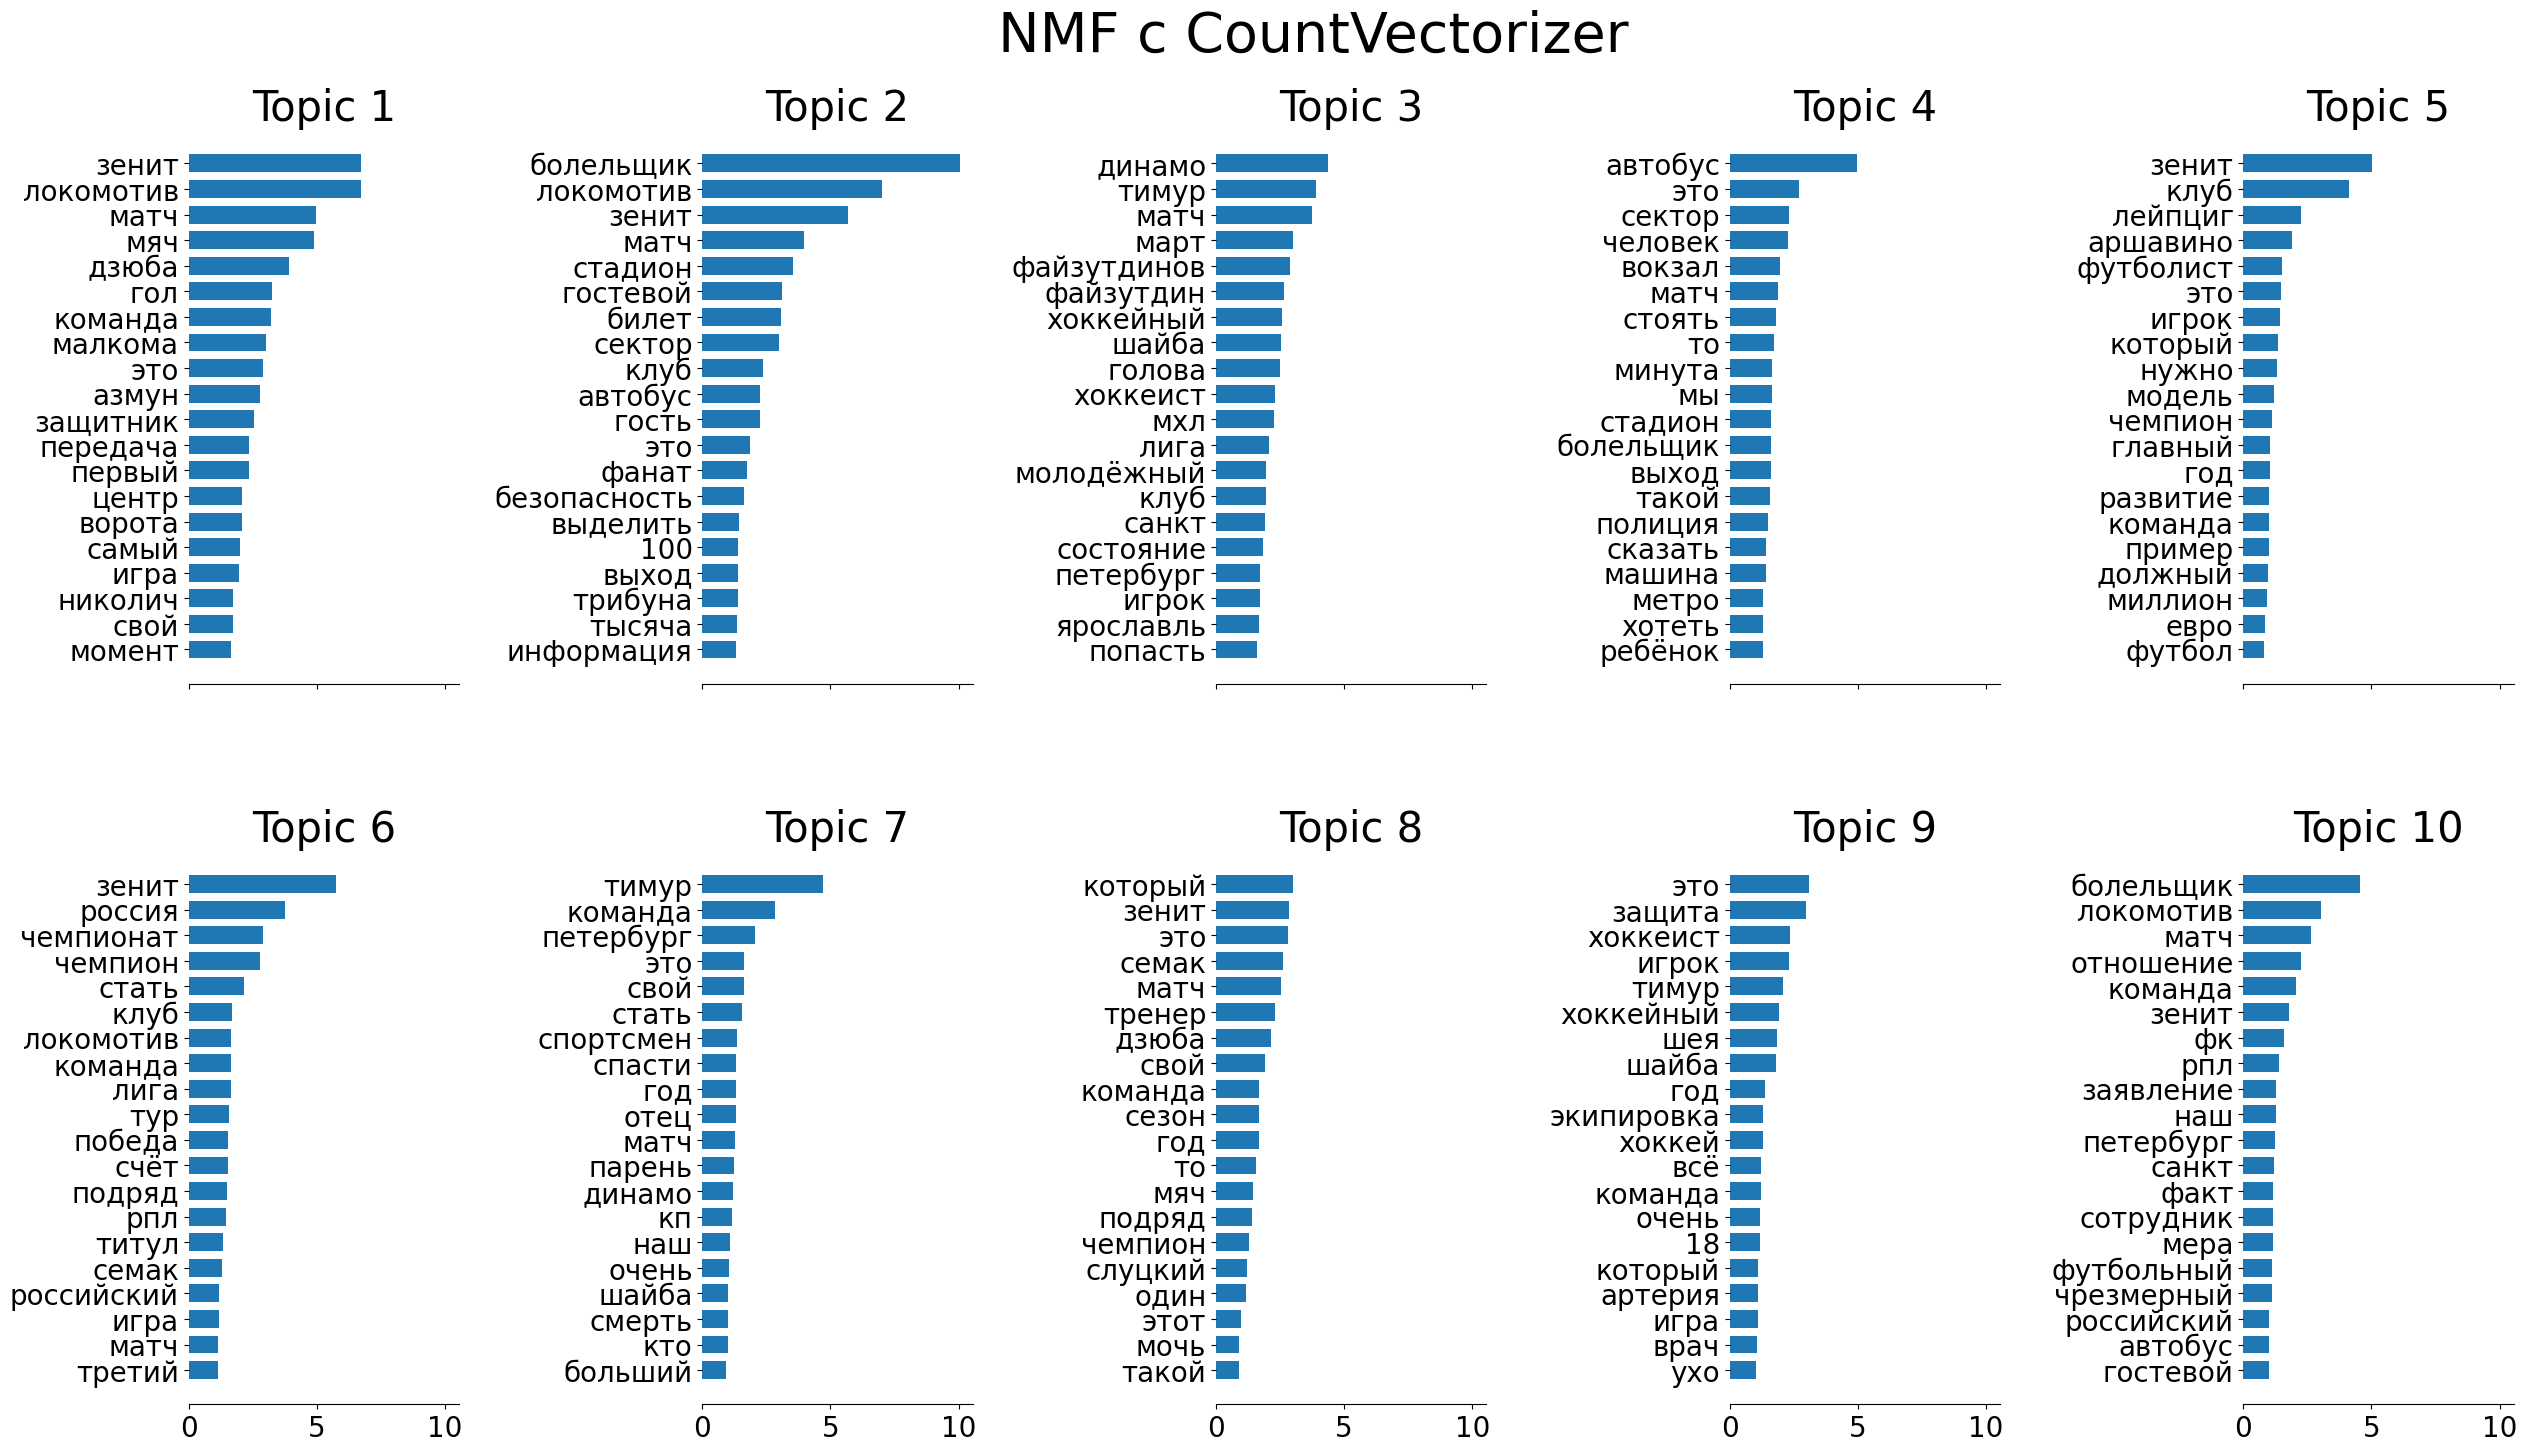

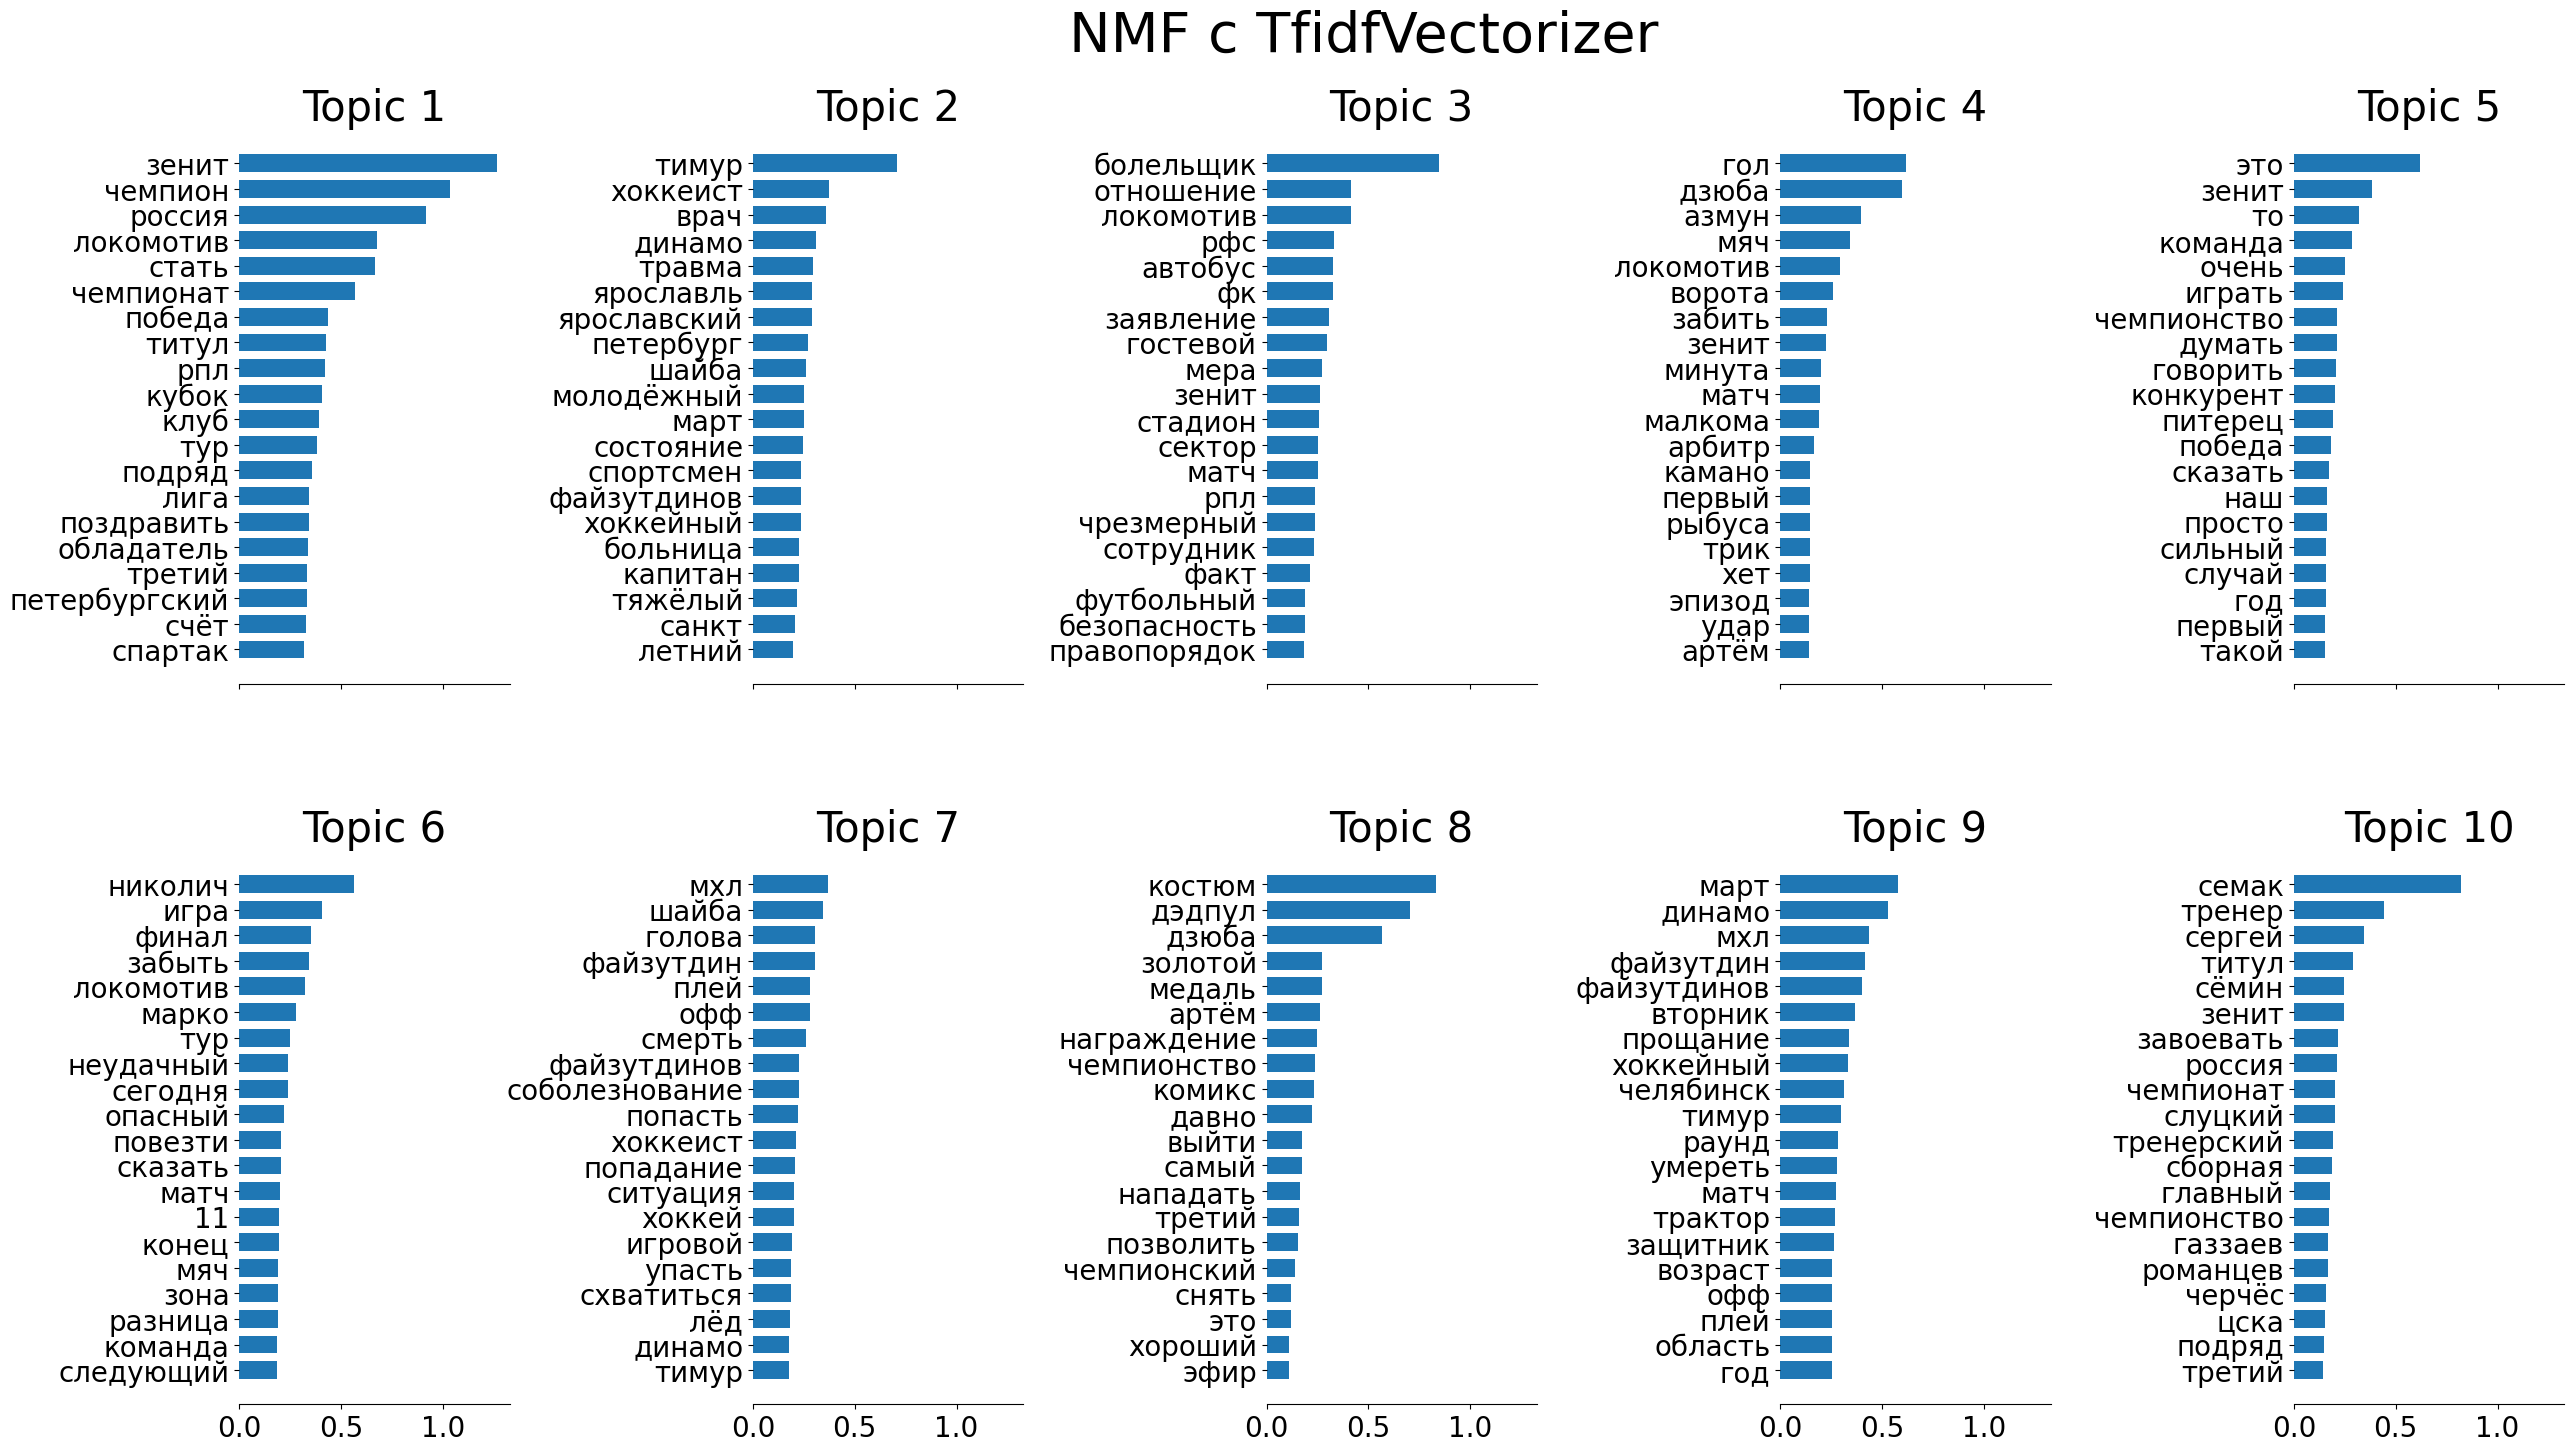

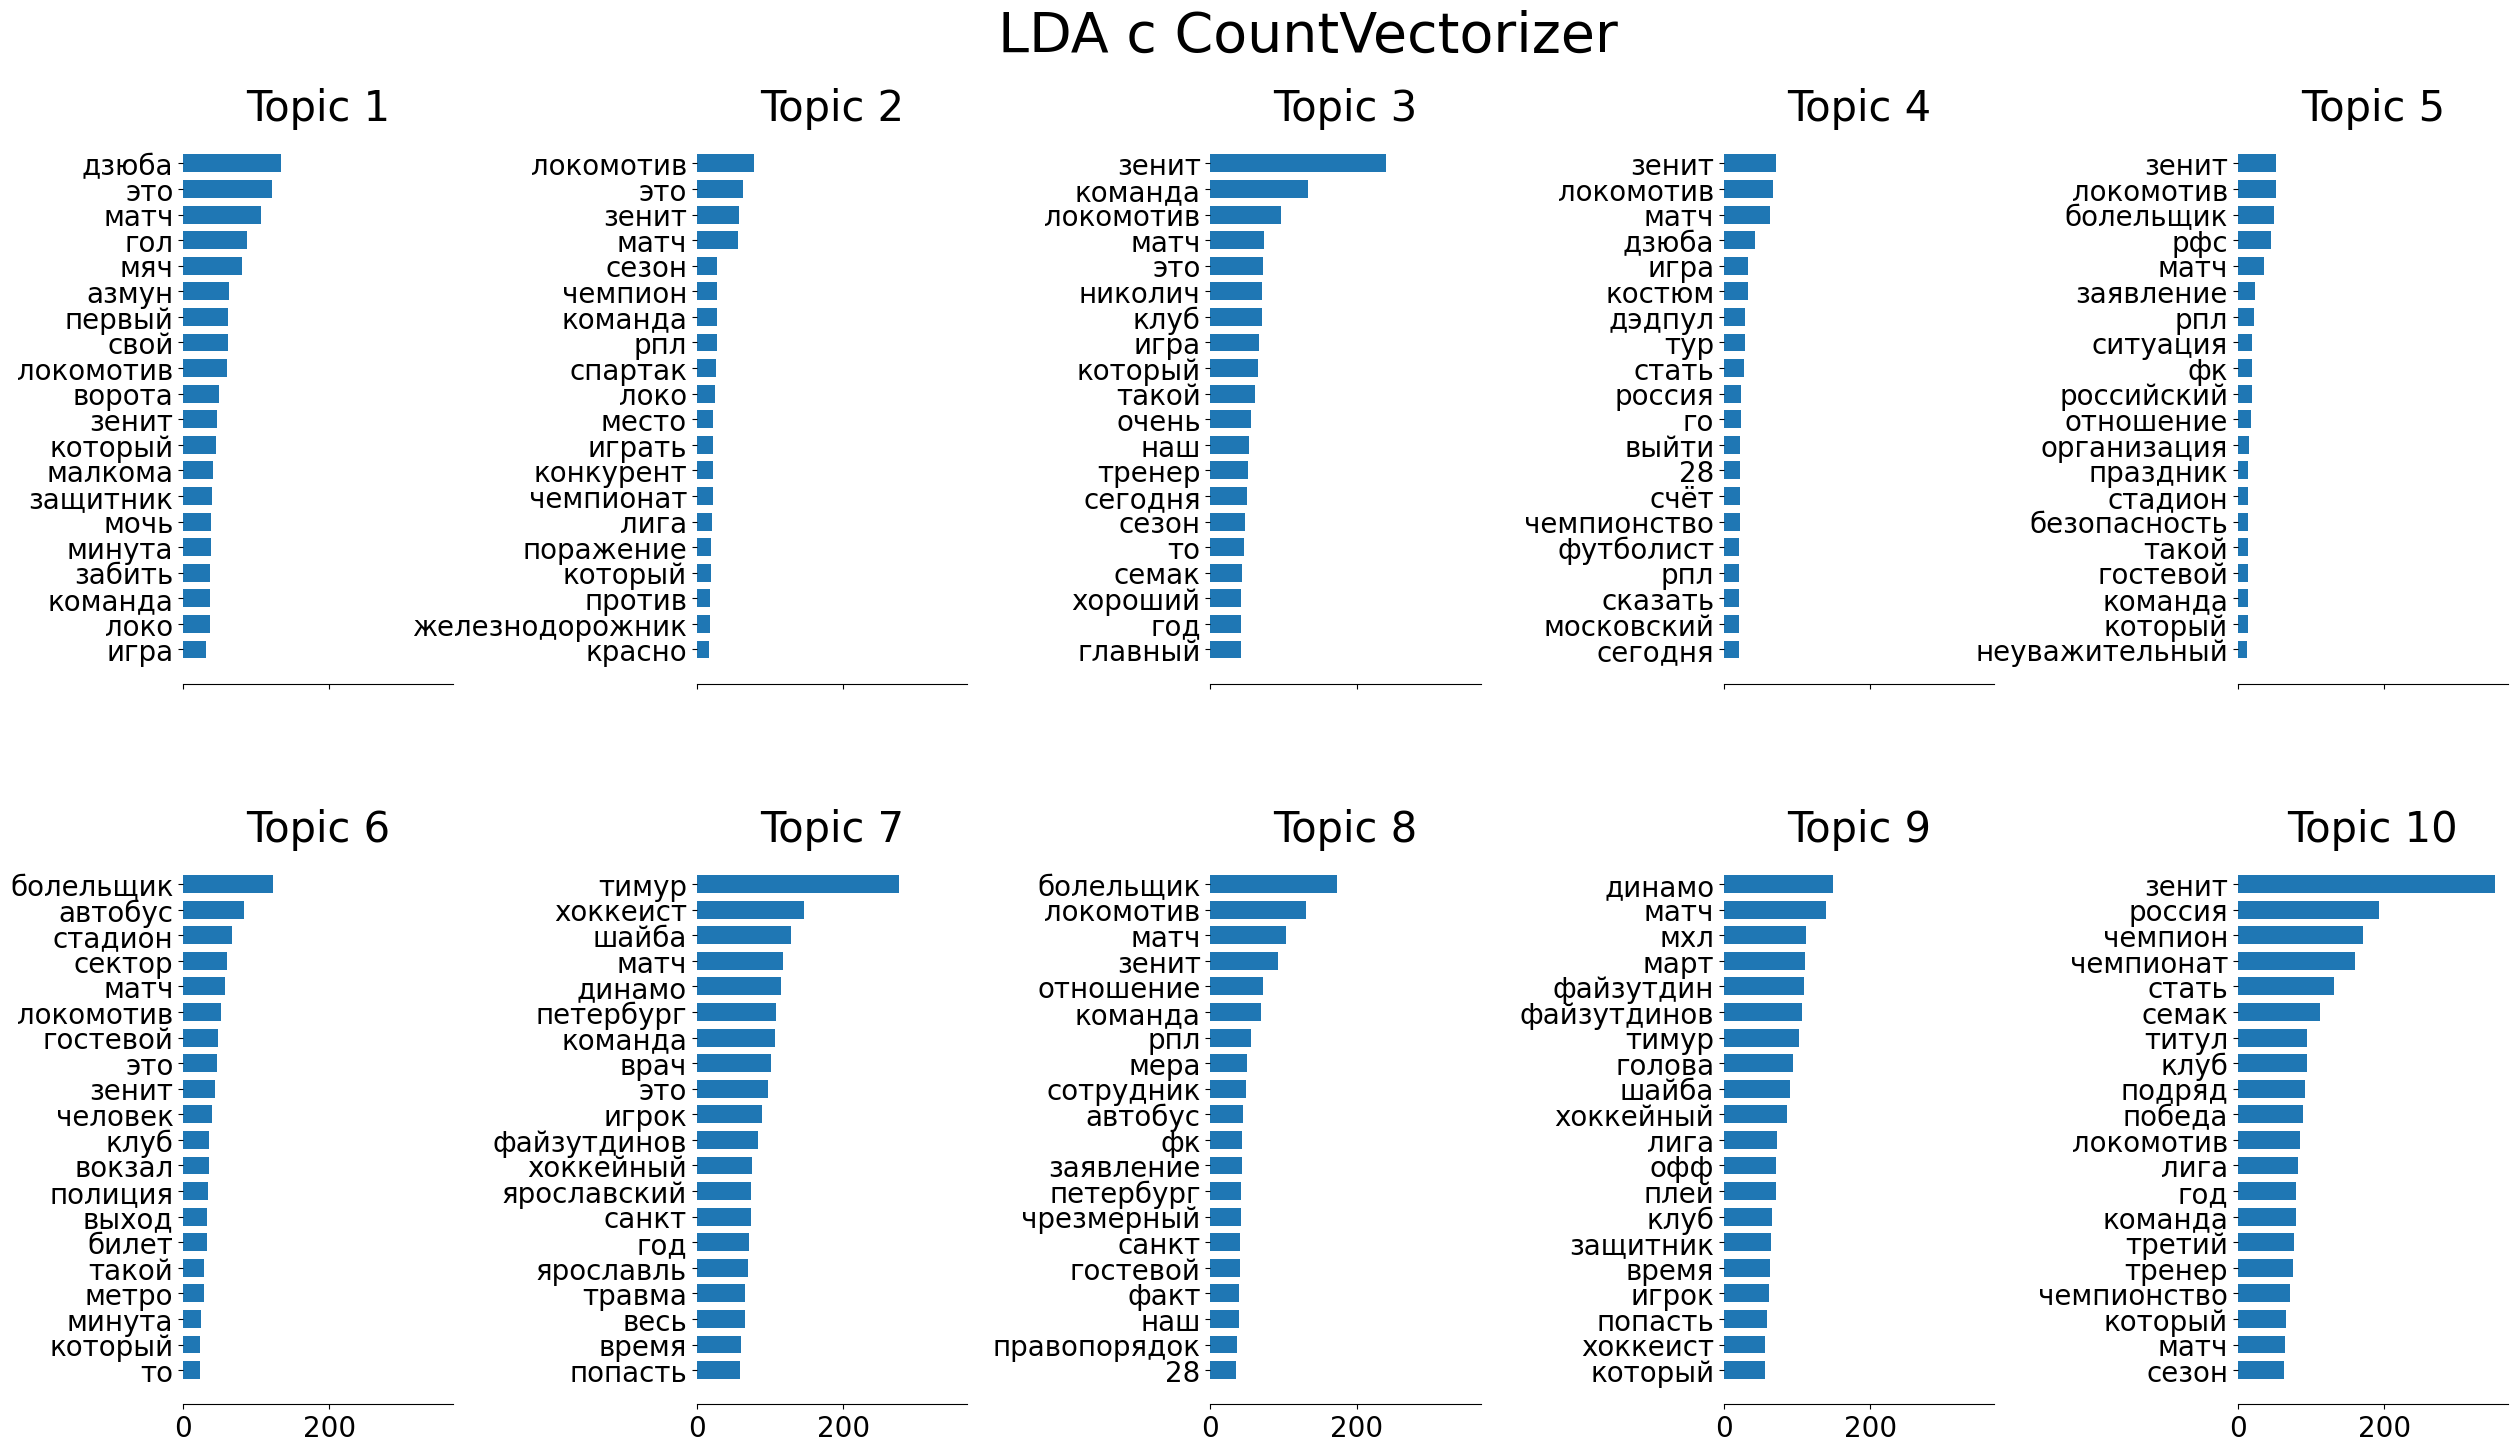

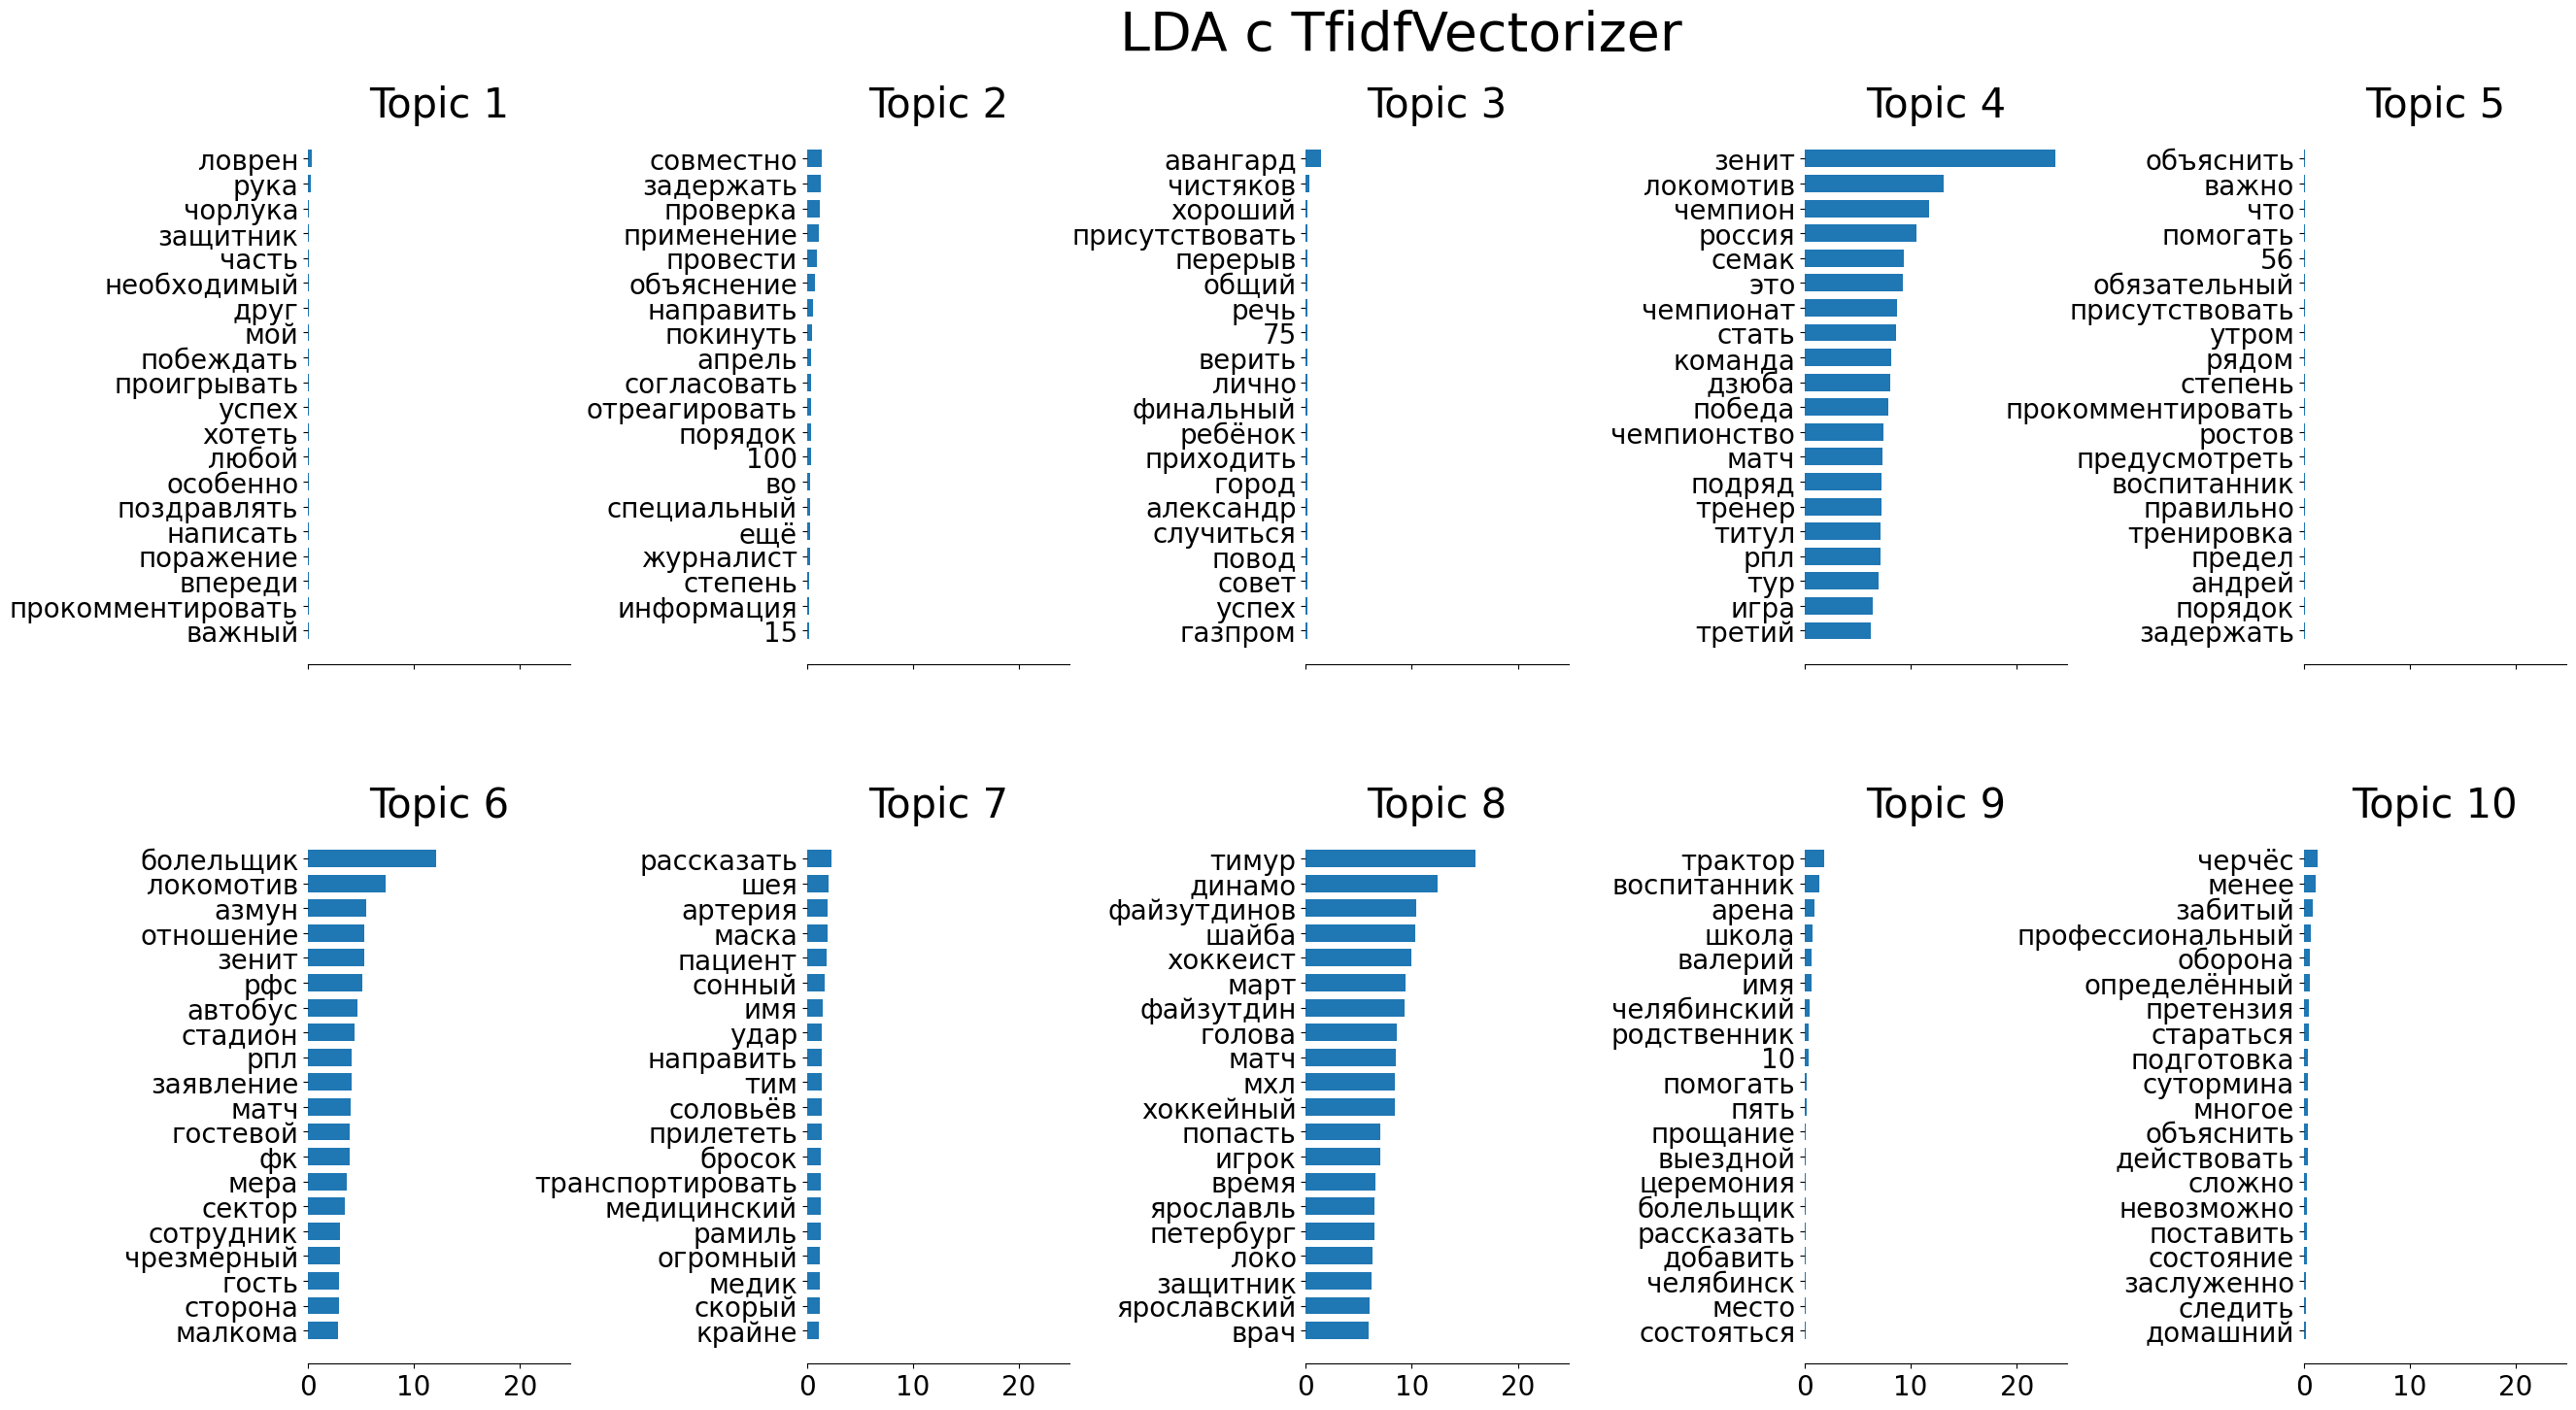

In [24]:
plot_top_words(nmf_count, tfidf_feature_names, n_top_words, 'NMF с CountVectorizer')         # Визуализация топ-слов для каждой модели
plot_top_words(nmf_tfidf, tfidf_feature_names, n_top_words, 'NMF с TfidfVectorizer')
plot_top_words(lda_count, tfidf_feature_names, n_top_words, 'LDA с CountVectorizer')
plot_top_words(lda_tfidf, tfidf_feature_names, n_top_words, 'LDA с TfidfVectorizer')